# [필터] block 과 window 기능

- 필터의 개념

### block : 이미지 전체의 일부 (안겹치게)

### window : 이미지 전체의 일부 (겹치게)

- orverwrapping 여부
---

In [1]:
import matplotlib.pyplot as plt
from skimage.util import view_as_blocks, view_as_windows
from skimage.data import camera
import numpy as np

In [2]:
data = camera()
data.shape

(512, 512)

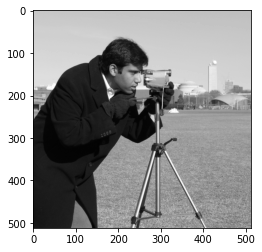

In [3]:
plt.imshow(data, cmap='gray')

In [4]:
data.shape

(512, 512)

In [5]:
# block : 겹치지 않고 쪼개는것

In [6]:
block = view_as_blocks(data, (4,4))
block.shape

# (128, 128, 4, 4) 의미
# 4 by 4 크기로 x 만큼 128개, y 만큼 128개로 쪼갰다.

(128, 128, 4, 4)

In [7]:
# 4차원에서 3차원으로 바꿈
block_flatten = block.reshape(128, 128, 16)

# 128 by 128 사진의 각 자리마다 16개의 데이터가 쌓여 있다.

In [8]:
# 평균으로 (대표 값으로 바꾸기)
np.mean(block_flatten, axis=2)

# axis = 축
# axis=0 : x 축을 기준으로 합을 구하는 방식
# axis=1 : y 축을 기준으로 합을 구하는 방식
# axis=2 : z 축을 기준으로 합을 구하는 방식

array([[199.5625, 199.25  , 198.75  , ..., 190.1875, 189.8125, 189.875 ],
       [200.    , 199.1875, 198.875 , ..., 190.4375, 190.625 , 190.625 ],
       [199.9375, 200.    , 199.25  , ..., 191.    , 190.5625, 190.6875],
       ...,
       [ 24.25  ,  24.0625,  23.375 , ..., 134.    , 150.25  , 156.4375],
       [ 24.6875,  24.    ,  24.5625, ..., 148.    , 138.25  , 130.4375],
       [ 25.25  ,  24.6875,  24.1875, ..., 158.25  , 153.3125, 151.5625]])

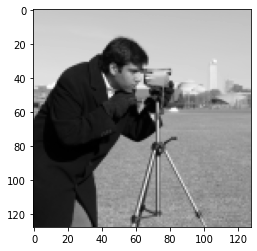

In [9]:
plt.imshow(np.mean(block_flatten, axis=2)/255, cmap='gray')
# 4 by 4 를 하나의 픽셀로 바꿔서 출력함
# 2차원으로 출력하기 위해 axis 개념을 씀

# 512 x 512  =>  128 x 128 로 바뀜 (이미지가 줄어듦 -> 4개의 점이 하나가 됨)

In [10]:
# plt.imshow(np.max(block_flatten, axis=2)/255, cmap='gray')
# plt.imshow(np.min(block_flatten, axis=2)/255, cmap='gray') # 전반적으로 어두워짐
# plt.imshow(np.median(block_flatten, axis=2)/255, cmap='gray')

---
### window 개념

4 by 4 로 한칸씩 이동 (겹친다.)

In [11]:
window = view_as_windows(data, (4,4))
window.shape

(509, 509, 4, 4)

---
# feature (block, window, feature 차이)

feature : 구분
- 이미지의 일부분 (오토바이 - 핸들, 바퀴, 안장, 엔진 등) 중 다른 부분과 구분이 가능한 부분
- 로컬의 featur / 글로벌 적 의미에서도 featur 가능

block : 이미지 전체의 일부 (안겹치게)

window : 이미지 전체의 일부 (겹치게)
- block 보다는 window가 디테일이 더 산다.

---



block : 각 값의 특성을 고려하지 않고, mean, max 등으로 퉁쳤음 (정보손실)  
- 특성을 반영해서 바꿀수 있다면 좋을텐데
- 4 by 4 라면, 16칸 의 각 특성을 반영해, 각 값의 가중평균 (가중치를 두어)한다면.
- WaA + WbB + WcC => A, B, C 의 특성(가중치)를 고려하면...


---
---
---
# Convloution // Correlation

In [12]:
import scipy
from scipy import ndimage  # skimage 이전에 이미지를 numpy 로 처리하게 해준 라이브러리
from scipy import signal

In [14]:
dir(ndimage)

"""
 'convolve',
 'convolve1d',
 'correlate',
 'correlate1d',
"""

"\n'convolve',\n'convolve1d',\n'correlate',\n'correlate1d',\n"

### correlation

In [25]:
# n by n 으로 이동함. 홀수 개가 의미가 있음
# 중간 칸을 중심으로 의미를
# n by n 을 : patch / kernel / filter 라고 함.

In [15]:
from scipy.signal import correlate

In [16]:
a = np.array([1,2,3,4,5])
b = np.array([-1,0,1])

correlate(a, b)

array([ 1,  2,  2,  2,  2, -4, -5])

In [22]:
# 순서를 바꾸면 값이 다름
correlate(b, a)

array([-5, -4,  2,  2,  2,  2,  1])

In [19]:
""" 계산 방법 ------------------ 다시 듣기...
a = image (고정)
b = kernal (움직임)

### correlate(a, b, mode = 'valid') 일때 계산
1)     [ 1,  2,  3,  4,  5]  - a 의 첫 자리와, b의 끝자리 계산
 [-1, 0, 1] 
 => (1*1) = 1
 
2)     [ 1,  2,  3,  4,  5]  - a 의 두 자리와, b의 끝 두자리 계산
   [-1,  0,  1]
=> (1*0) + (2*1) = 2

3)     [ 1,  2,  3,  4,  5]  - a 의 세 자리와, b의 끝 세자리 계산
       [-1,  0,  1]
=> (1*-1) + (1*0) + (2*1) = 2

--------------------------------------
### correlate(a, b, mode = 'full') 일때 계산
1) [ 0, 0, 1,  2,  3,  4,  5, 0, 0]  - a 의 모자란 부분을 0으로 확장 시켜 계산
   [-1, 0, 1] 
   => (0*-1) + (0*0) + (1*1) = 1
   
--------------------------------------
### correlate(a, b, mode = 'same') 일때 계산
1)    [ 0, 1,  2,  3,  4,  5, 0]  - a 의 크기 5개와 같은 길이 값이 나오도록 만 확장
   [-1, 0, 1] 
   => (0*-1) + (0*0) + (1*1) = 1
   
""";

In [20]:
correlate(a,b,mode='valid')

array([2, 2, 2])

In [21]:
correlate(a,b,mode='full')

array([ 1,  2,  2,  2,  2, -4, -5])

In [29]:
correlate(a,b,mode='same')

array([ 2,  2,  2,  2, -4])

____

In [23]:
from scipy.ndimage import correlate
# 이미지 이므로 2차원 연산이 기본.

# mode 종류가 추가됨 (가장자리 만드는 기술)
# mode = reflact ( u-net 에 사용)
# mode = mirror
# mode = wran

# ------
# correlate 에 flip 을 추가 한 것
# b 를 좌우 반전 하여 [1,0,-1] 하여 correlation 한 것 => convolution

In [25]:
a = np.array([1,2,3,4,5])
b = np.array([-1,0,1])

correlate(a, b)

array([1, 2, 2, 2, 1])

In [33]:
help(correlate)

Help on function correlate in module scipy.ndimage._filters:

correlate(input, weights, output=None, mode='reflect', cval=0.0, origin=0)
    Multidimensional correlation.
    
    The array is correlated with the given kernel.
    
    Parameters
    ----------
    input : array_like
        The input array.
    weights : ndarray
        array of weights, same number of dimensions as input
    output : array or dtype, optional
        The array in which to place the output, or the dtype of the
        returned array. By default an array of the same dtype as input
        will be created.
    mode : {'reflect', 'constant', 'nearest', 'mirror', 'wrap'}, optional
        The `mode` parameter determines how the input array is extended
        beyond its boundaries. Default is 'reflect'. Behavior for each valid
        value is as follows:
    
        'reflect' (`d c b a | a b c d | d c b a`)
            The input is extended by reflecting about the edge of the last
            pixel. This